In [39]:
import gzip
import csv
import os
import json
import gzip
import ast
from tqdm import tqdm

import pandas as pd
from datetime import datetime

import re

from textblob import TextBlob

from langdetect import detect, DetectorFactory

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Set style for charts
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# Review Data Analysis

In [44]:
review_data = []
with gzip.open("dataset/australian_user_reviews.json.gz", "rt", encoding="utf-8") as f:
    for line in f:
        obj = ast.literal_eval(line)   # parses python dict syntax
        review_data.append(obj)

print(len(review_data))
print(review_data[0])



25799
{'user_id': '76561197970982479', 'user_url': 'http://steamcommunity.com/profiles/76561197970982479', 'reviews': [{'funny': '', 'posted': 'Posted November 5, 2011.', 'last_edited': '', 'item_id': '1250', 'helpful': 'No ratings yet', 'recommend': True, 'review': 'Simple yet with great replayability. In my opinion does "zombie" hordes and team work better than left 4 dead plus has a global leveling system. Alot of down to earth "zombie" splattering fun for the whole family. Amazed this sort of FPS is so rare.'}, {'funny': '', 'posted': 'Posted July 15, 2011.', 'last_edited': '', 'item_id': '22200', 'helpful': 'No ratings yet', 'recommend': True, 'review': "It's unique and worth a playthrough."}, {'funny': '', 'posted': 'Posted April 21, 2011.', 'last_edited': '', 'item_id': '43110', 'helpful': 'No ratings yet', 'recommend': True, 'review': 'Great atmosphere. The gunplay can be a bit chunky at times but at the end of the day this game is definitely worth it and I hope they do a seque

In [45]:
# Flatten the dataset (one row per review)
rows = []
for user in review_data:
    for r in user["reviews"]:
        rows.append({
            "user_id": user["user_id"],
            "game_id": r["item_id"],
            "posted": r["posted"],
            "recommend": r["recommend"],
            "text": r["review"]
        })

review_df = pd.DataFrame(rows)
review_df.head()


,user_id,game_id,posted,recommend,text
0,76561197970982479,1250,"Posted November 5, 2011.",True,Simple yet with great replayability. In my opi...
1,76561197970982479,22200,"Posted July 15, 2011.",True,It's unique and worth a playthrough.
2,76561197970982479,43110,"Posted April 21, 2011.",True,Great atmosphere. The gunplay can be a bit chu...
3,js41637,251610,"Posted June 24, 2014.",True,I know what you think when you see this title ...
4,js41637,227300,"Posted September 8, 2013.",True,For a simple (it's actually not all that simpl...


In [46]:
def detect_lang_safe(text):
    try:
        return detect(text)
    except:
        return "unknown"

review_df["lang"] = review_df["text"].apply(detect_lang_safe)

non_english_count = (review_df["lang"] != "en").sum()

review_df["lang"].value_counts()

lang
en         45723
pt          2184
es          1283
de          1145
so          1018
af           751
th           715
unknown      591
tl           590
cy           464
da           419
no           385
nl           315
ca           268
it           255
ro           249
id           247
pl           246
ko           241
fr           232
ru           213
zh-cn        208
et           185
sw           178
tr           164
hr           143
sl           136
vi           122
fi           100
sq            99
hu            97
sk            75
sv            69
lt            40
cs            38
ja            36
lv            33
bg            20
uk            11
zh-tw          7
mk             7
ar             2
ta             1
Name: count, dtype: int64

In [47]:
print(non_english_count)

13582


In [51]:
print("Number of users:", review_df["user_id"].nunique())
print("Number of reviews:", len(review_df))
print("Number of games:", review_df["game_id"].nunique())
print("Recommend rate:", review_df["recommend"].mean())

Number of users: 25458
Number of reviews: 59305
Number of games: 3682
Recommend rate: 0.8847989208329821


In [49]:
review_df["length"] = review_df["text"].str.len()
review_df["length"].describe()

count    59305.00000
mean       215.66620
std        455.28899
min          0.00000
25%         30.00000
50%         78.00000
75%        207.00000
max       8000.00000
Name: length, dtype: float64

In [50]:
review_df["sentiment"] = review_df["text"].apply(lambda t: TextBlob(t).sentiment.polarity)
review_df["sentiment"].describe()

count    59305.000000
mean         0.114618
std          0.294723
min         -1.000000
25%          0.000000
50%          0.059016
75%          0.250000
max          1.000000
Name: sentiment, dtype: float64

/var/folders/d_/qt9yhc2549s7ghqsdf91y2l40000gn/T/ipykernel_90766/3429354671.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="recommend", data=review_df, palette="viridis")


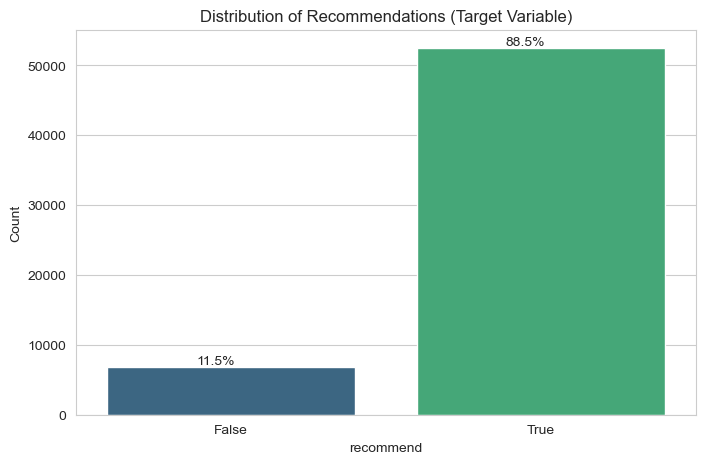

Skewness of Sentiment: 0.37223498755480333


In [52]:
# Cell: Target Variable Distribution
plt.figure(figsize=(8, 5))
ax = sns.countplot(x="recommend", data=review_df, palette="viridis")
plt.title("Distribution of Recommendations (Target Variable)")
plt.ylabel("Count")

# Add percentage labels
total = len(review_df)
for p in ax.patches:
    percentage = "{:.1f}%".format(100 * p.get_height() / total)
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha="center", va="bottom")
plt.show()

print(f"Skewness of Sentiment: {review_df['sentiment'].skew()}")

/var/folders/d_/qt9yhc2549s7ghqsdf91y2l40000gn/T/ipykernel_90766/1177858626.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="recommend", y="sentiment", data=review_df, palette="coolwarm")


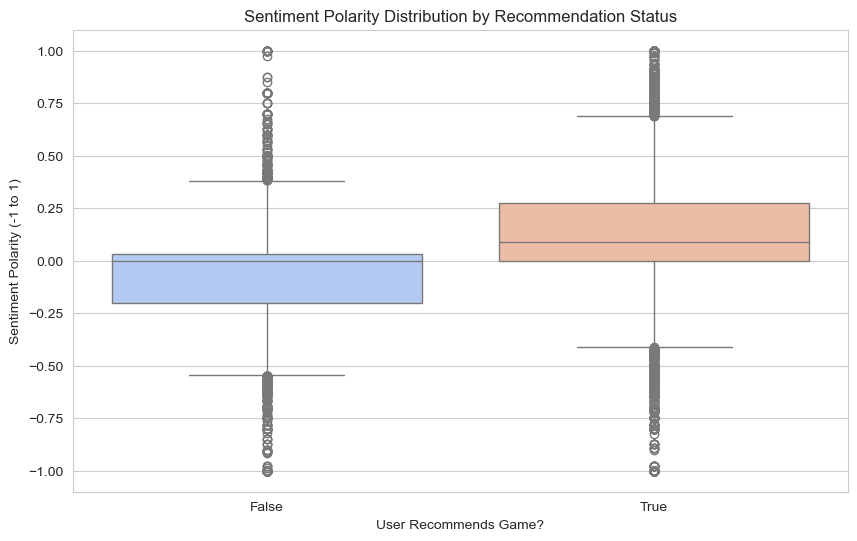

In [53]:
# Cell: Sentiment vs Recommendation
plt.figure(figsize=(10, 6))
sns.boxplot(x="recommend", y="sentiment", data=review_df, palette="coolwarm")
plt.title("Sentiment Polarity Distribution by Recommendation Status")
plt.xlabel("User Recommends Game?")
plt.ylabel("Sentiment Polarity (-1 to 1)")
plt.show()

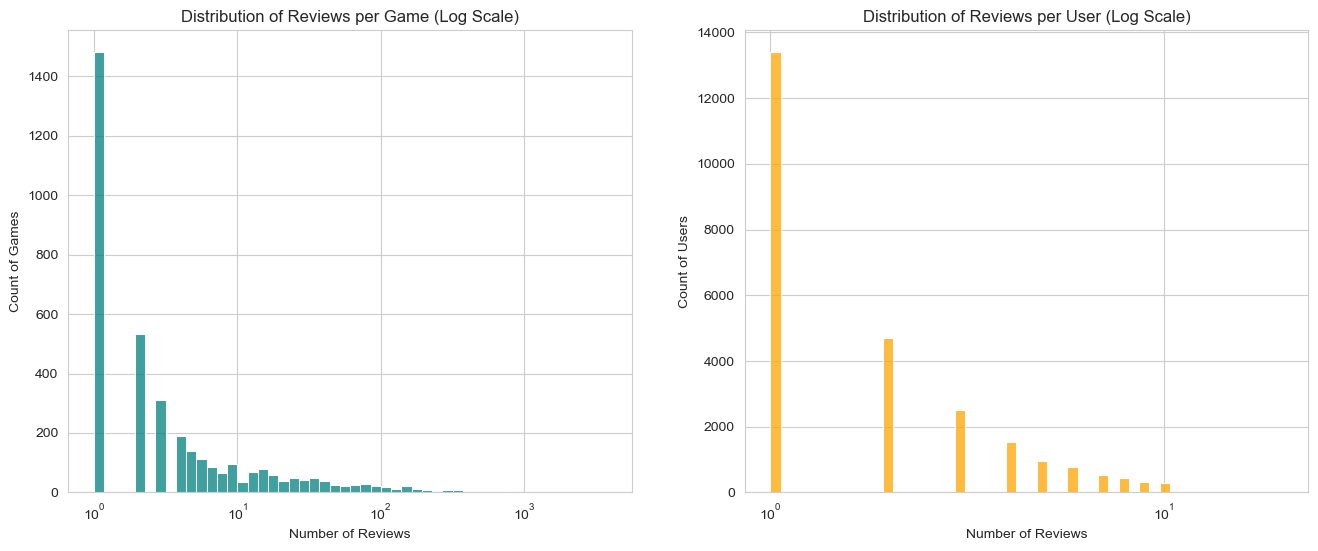

Unique Games: 3682
Games with < 5 reviews: 2513


In [54]:
# Cell: The Long Tail - Users and Items
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Reviews per Game
game_review_counts = review_df["game_id"].value_counts()
sns.histplot(game_review_counts, bins=50, log_scale=True, ax=axes[0], color="teal")
axes[0].set_title("Distribution of Reviews per Game (Log Scale)")
axes[0].set_xlabel("Number of Reviews")
axes[0].set_ylabel("Count of Games")

# 2. Reviews per User
user_review_counts = review_df["user_id"].value_counts()
sns.histplot(user_review_counts, bins=50, log_scale=True, ax=axes[1], color="orange")
axes[1].set_title("Distribution of Reviews per User (Log Scale)")
axes[1].set_xlabel("Number of Reviews")
axes[1].set_ylabel("Count of Users")

plt.show()

print(f"Unique Games: {len(game_review_counts)}")
print(f"Games with < 5 reviews: {sum(game_review_counts < 5)}")

# User Data Analysis

In [19]:
import gzip
import ast
from tqdm import tqdm

user_data = []

# Optionally, get the total number of lines for a proper progress bar
with gzip.open("dataset/australian_users_items.json.gz", "rt", encoding="utf-8") as f:
    for line in tqdm(f, desc="Loading data"):
        obj = ast.literal_eval(line)  # parses python dict syntax
        user_data.append(obj)

print(len(user_data))
print(user_data[0])


Loading data: 88310it [01:05, 1340.89it/s]

88310
{'user_id': '76561197970982479', 'items_count': 277, 'steam_id': '76561197970982479', 'user_url': 'http://steamcommunity.com/profiles/76561197970982479', 'items': [{'item_id': '10', 'item_name': 'Counter-Strike', 'playtime_forever': 6, 'playtime_2weeks': 0}, {'item_id': '20', 'item_name': 'Team Fortress Classic', 'playtime_forever': 0, 'playtime_2weeks': 0}, {'item_id': '30', 'item_name': 'Day of Defeat', 'playtime_forever': 7, 'playtime_2weeks': 0}, {'item_id': '40', 'item_name': 'Deathmatch Classic', 'playtime_forever': 0, 'playtime_2weeks': 0}, {'item_id': '50', 'item_name': 'Half-Life: Opposing Force', 'playtime_forever': 0, 'playtime_2weeks': 0}, {'item_id': '60', 'item_name': 'Ricochet', 'playtime_forever': 0, 'playtime_2weeks': 0}, {'item_id': '70', 'item_name': 'Half-Life', 'playtime_forever': 0, 'playtime_2weeks': 0}, {'item_id': '130', 'item_name': 'Half-Life: Blue Shift', 'playtime_forever': 0, 'playtime_2weeks': 0}, {'item_id': '300', 'item_name': 'Day of Defeat: Sour

In [20]:
# Flatten the dataset (one row per user-game pair)
rows = []
for user in user_data:
    for g in user["items"]:
        rows.append({
            "user_id": user["user_id"],
            "game_id": g["item_id"],
            "game_name": g["item_name"],
            "total_playtime": g["playtime_forever"],
            "recent_playtime": g["playtime_2weeks"]
        })

user_df = pd.DataFrame(rows)
user_df.head()

,user_id,game_id,game_name,total_playtime,recent_playtime
0,76561197970982479,10,Counter-Strike,6,0
1,76561197970982479,20,Team Fortress Classic,0,0
2,76561197970982479,30,Day of Defeat,7,0
3,76561197970982479,40,Deathmatch Classic,0,0
4,76561197970982479,50,Half-Life: Opposing Force,0,0


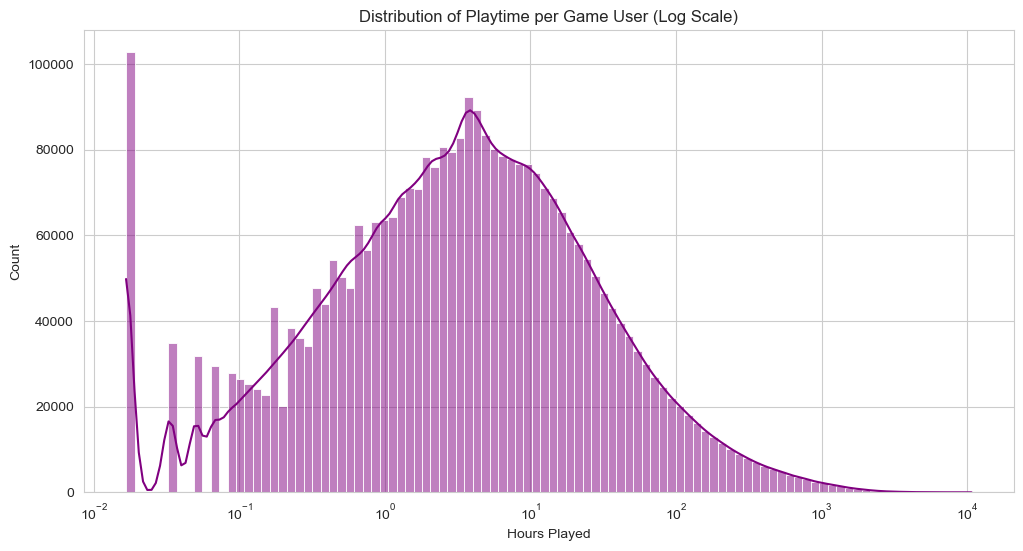

Top 10 Most Played Games (Total Hours):
game_name
Counter-Strike: Global Offensive    1.308640e+07
Garry's Mod                         7.472777e+06
Terraria                            2.582909e+06
The Elder Scrolls V: Skyrim         2.277977e+06
Warframe                            2.067128e+06
Counter-Strike: Source              1.876867e+06
Left 4 Dead 2                       1.703157e+06
PAYDAY 2                            1.662732e+06
Sid Meier's Civilization V          1.373011e+06
Rust                                1.352007e+06
Name: hours_played, dtype: float64


In [55]:
# Cell: Playtime Distribution
# Convert minutes to hours for readability
user_df["hours_played"] = user_df["total_playtime"] / 60

# Filter out 0 playtime (backlog games) to see actual engagement
played_games = user_df[user_df["hours_played"] > 0]

plt.figure(figsize=(12, 6))
sns.histplot(
    played_games["hours_played"], bins=100, log_scale=True, kde=True, color="purple"
)
plt.title("Distribution of Playtime per Game User (Log Scale)")
plt.xlabel("Hours Played")
plt.show()

# Top 10 Most Played Games by Total Hours across all users
top_played = (
    user_df.groupby("game_name")["hours_played"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
)
print("Top 10 Most Played Games (Total Hours):")
print(top_played)

# Game Data Analysis

In [22]:
import gzip
import ast
from tqdm import tqdm

game_data = []

# Optionally, get the total number of lines for a proper progress bar
with gzip.open("dataset/steam_games.json.gz", "rt", encoding="utf-8") as f:
    for line in tqdm(f, desc="Loading data"):
        obj = ast.literal_eval(line)  # parses python dict syntax
        game_data.append(obj)

print(len(game_data))
print(game_data[0])

Loading data: 32135it [00:02, 12294.17it/s]

32135
{'publisher': 'Kotoshiro', 'genres': ['Action', 'Casual', 'Indie', 'Simulation', 'Strategy'], 'app_name': 'Lost Summoner Kitty', 'title': 'Lost Summoner Kitty', 'url': 'http://store.steampowered.com/app/761140/Lost_Summoner_Kitty/', 'release_date': '2018-01-04', 'tags': ['Strategy', 'Action', 'Indie', 'Casual', 'Simulation'], 'discount_price': 4.49, 'reviews_url': 'http://steamcommunity.com/app/761140/reviews/?browsefilter=mostrecent&p=1', 'specs': ['Single-player'], 'price': 4.99, 'early_access': False, 'id': '761140', 'developer': 'Kotoshiro'}


In [37]:
# Flatten the dataset (one row per user-game pair)
rows = []
for game in game_data:
    rows.append(
        {
            "title": game["title"] if "title" in game.keys() else "",
            "game_id": game["id"] if "id" in game.keys() else None,
            "publisher": game["publisher"] if "publisher" in game.keys() else None,
            "developer": game["developer"] if "developer" in game.keys() else None,
            "release_date": (
                game["release_date"] if "release_date" in game.keys() else None
            ),
            "price": game["price"] if "price" in game.keys() else None,
            "genres": game["genres"] if "genres" in game.keys() else [],
            "tags": game["tags"] if "tags" in game.keys() else [],
            "specs": game["specs"] if "specs" in game.keys() else [],
        }
    )

game_df = pd.DataFrame(rows)
game_df.head()

,title,game_id,publisher,developer,release_date,price,genres,tags,specs
0,Lost Summoner Kitty,761140,Kotoshiro,Kotoshiro,2018-01-04,4.99,"[Action, Casual, Indie, Simulation, Strategy]","[Strategy, Action, Indie, Casual, Simulation]",[Single-player]
1,Ironbound,643980,"Making Fun, Inc.",Secret Level SRL,2018-01-04,Free To Play,"[Free to Play, Indie, RPG, Strategy]","[Free to Play, Strategy, Indie, RPG, Card Game...","[Single-player, Multi-player, Online Multi-Pla..."
2,Real Pool 3D - Poolians,670290,Poolians.com,Poolians.com,2017-07-24,Free to Play,"[Casual, Free to Play, Indie, Simulation, Sports]","[Free to Play, Simulation, Sports, Casual, Ind...","[Single-player, Multi-player, Online Multi-Pla..."
3,弹炸人2222,767400,彼岸领域,彼岸领域,2017-12-07,0.99,"[Action, Adventure, Casual]","[Action, Adventure, Casual]",[Single-player]
4,,773570,None,None,None,2.99,[],"[Action, Indie, Casual, Sports]","[Single-player, Full controller support, HTC V..."


/var/folders/d_/qt9yhc2549s7ghqsdf91y2l40000gn/T/ipykernel_90766/2252391474.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_genres.values, y=top_genres.index, palette="magma")


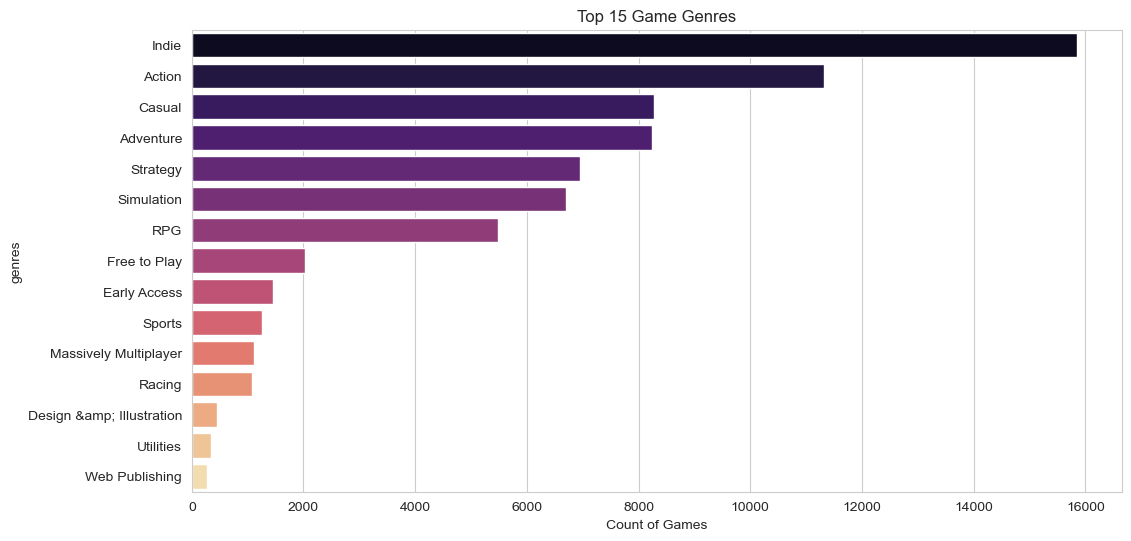

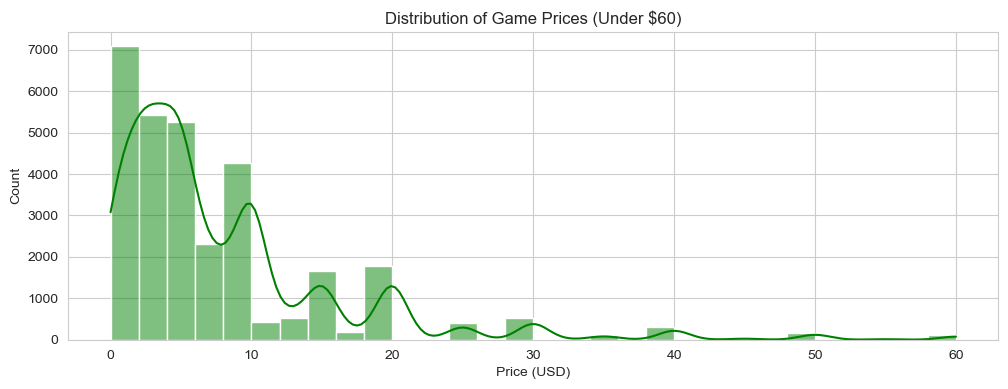

In [56]:
# Cell: Cleaning Price and Genres

# 1. Clean Price
def clean_price(x):
    if isinstance(x, str):
        if "free" in x.lower():
            return 0.0
        try:
            return float(x)
        except:
            return np.nan
    return x


game_df["clean_price"] = game_df["price"].apply(clean_price)

# 2. Explode Genres for visualization
genres_exploded = game_df.explode("genres")

# Plot Top Genres
plt.figure(figsize=(12, 6))
top_genres = genres_exploded["genres"].value_counts().head(15)
sns.barplot(x=top_genres.values, y=top_genres.index, palette="magma")
plt.title("Top 15 Game Genres")
plt.xlabel("Count of Games")
plt.show()

# Plot Price Distribution (Under $60)
plt.figure(figsize=(12, 4))
sns.histplot(
    game_df[game_df["clean_price"] < 60]["clean_price"],
    bins=30,
    kde=True,
    color="green",
)
plt.title("Distribution of Game Prices (Under $60)")
plt.xlabel("Price (USD)")
plt.show()

## Combining Data into Interactions

Reviews: 59305
User Inventory Items: 5153209
Overlapping Interactions (Played AND Reviewed): 46317


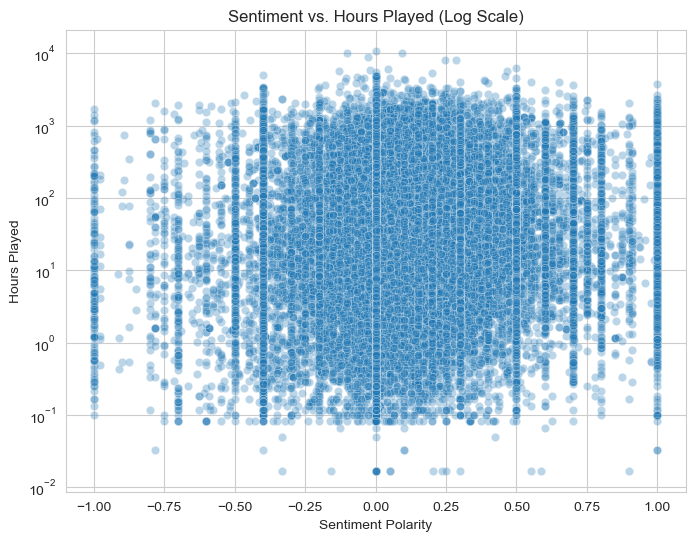

In [57]:
# Cell: Merging Reviews and Playtime
# We merge on user_id and game_id (renaming item_id to game_id if necessary)
# Note: user_df has 'game_id' as string, review_df has 'game_id' as string. Ensure types match.

combined_df = pd.merge(review_df, user_df, on=["user_id", "game_id"], how="inner")

print(f"Reviews: {len(review_df)}")
print(f"User Inventory Items: {len(user_df)}")
print(f"Overlapping Interactions (Played AND Reviewed): {len(combined_df)}")

# Correlation between Playtime and Sentiment
# Do people play games longer if they like them?
plt.figure(figsize=(8, 6))
sns.scatterplot(x="sentiment", y="hours_played", data=combined_df, alpha=0.3)
plt.yscale("log")
plt.title("Sentiment vs. Hours Played (Log Scale)")
plt.ylabel("Hours Played")
plt.xlabel("Sentiment Polarity")
plt.show()